# Analysis on Impact of Crime on Housing Prices in Chicago

## Chavi Gupta

----

## I. Introduction
Safety has been considered a fundamental human right since the beginning of the human rights era. Maintaining Law and Order is one the most basic and important responsibilities of any local government. Crime rate thus becomes a very important indicator for comparing neighborhoods. One of the most studied effects of crime is the impact it has on the housing and rental rates in any communities. One of the easiest ways to measure crime is to explore the housing and rental rates in a given area. The goal of this project is to study the relationship betweeen crime rate and housing prices in Chicago city and the to discover patterns in the types of crimes that effect housing prices more than others.

## II. Background
My inspiration for this analysis is based on the work done by Harold Li that can be found on [Databucket](https://databuckets.org/databucket/2016/01/exploring-chicago-crime-and-housing.html). The analysis for this research was based on Trulia API data. The results from his work showed that crime rates inversely impact housing rates and there is a non-linear relationship between them. To add to this analysis, I would like to also see if different crime types have different effects on the housing prices.

## III. Data
For this project I have used four different datasets to create data for my analysis. I used the [Zillow Dataset](https://www.zillow.com/research/data/) to get the housing prices for neighborhoods in Chicago. For crime I used the Chicago Crimes dataset that is publically available on [the official website of the City of Chicago](https://data.cityofchicago.org/Public-Safety/Crimes-2019/w98m-zvie) under the following [Terms of Use](https://www.chicago.gov/city/en/narr/foia/data_disclaimer.html). In order to normalize the crime counts based on the neighborhood poplulations, I used the 2010 Census data for the population at neighborhood level. The data is available from the [Datahub website](https://datahub.cmap.illinois.gov/dataset/community-data-snapshots-raw-data/resource/8c4e096e-c90c-4bef-9cf1-9028d094296e?inner_span=True). Finally for mapping the latitude-longitude coordinates in the crime dataset to Zillow defined neighborhoods, I used the nieghborhood boundary data generated in the [github repository](https://github.com/mashvisor/us-neighborhoods-boundaries/blob/master/out/csv/IL-Regions.csv). 

**Ethical Considerations:** Note that the Zillow dataset reports the Zillow Home Value Index (ZHVI) for All Homes (SFR, Condo/Co-op) based on Neighborhood. The ZHVI is derived as the median house price for all estimated house prices in an area and adjusted for seasonality and estimation errors. (More information about ZHVI can be read from [ZHVI Overview](https://www.zillow.com/research/zhvi-methodology-2019-highlights-26221/) and [a deep-dive into it's methodology](https://www.zillow.com/research/zhvi-methodology-2019-deep-26226/)) The dataset thus does not contain the actual housing price for any individual property. It also does not contain any additional information about home owners or buyers. The crime data does not contain any identifiers such as name, age, gender, race or religion of neither the criminals nor the victims. Both datasets do not leak any private information about any persons.

## IV. Research Questions

 - **Q1:** Is there a strong relationship between crime rates and housing prices in Chicago at the neighborhood level? Are changes in  crime rates a strong predictor for changes in housing prices?  
     
  
  
 - **Q2:** Do different types of crimes have different effects on the housing prices?  
     
## V. Methodology
- For determining the relationship between the crime rates and the housing prices (Q1), I have performed a linear regression (housing price ~ crime rate) to understand the relationship between the crime rates and housing prices. This involved analyzing non-linear relationships and variables transformations through techniques like the boxcox method and comparison of diagnostic plots and the goodness of fit measure - $R^2$.  
The $R^2$ value would determine whether changes in crime rates are a strong predictor for housing prices.  
     
  
  
- For determining the effect of different types of crimes on the housing prices (Q2), I plan to fit a linear regression (housing price ~ crime rate + crime type) to see whether there is a substantial difference between the coefficients of different crime types. I also plan to perform an Anova test to determine whether the crime type has a significant effect on the housing prices.

## VI. Reproducibility

Each individual section of the data preparation (refer to the [Data preparation notebook](data-preparation.ipynb)) and [analysis](#IX.-Analysis) can be reproduced in its entirety. To reproduce the analysis, the following softwares have to be installed

1. python
2. pandas
3. numpy
4. statsmodel
5. scipy
6. seaborn
7. matplotlib




## VII. Data Considerations
Since the different crime types are unequally distributed, studying the effect of different crime rates on the housing prices may not have very clear results. For eg, Crimes that are not so common (eg:-HUMAN TRAFFICKING, PUBLIC INDECENCY) may not occur in multiple neighborhoods. In this case there would be fewer data points and thus the regression may be skewed. In order to handle this I have decided to select only serious crimes as defined in [Harold Li's analysis](https://github.com/haroldmli/01-Chicago-Crime-Rates-and-Housing-Prices/blob/master/Project_1_Crime_House_Prices.ipynb). These crimes are selected based on severity and have sufficient data points.

## VIII. Data Creation

For the analysis, I need to get crime and price (ZHVI) data for different neightborhoods in Chicago. I also need to get the population data in order to normalize the number of crimes and obtain crime rates for each neighborhood. For this I have used four different datasets as explained in the Dataset section. The steps to prepare the final dataset can be refered to from the [Data Preparation notebook](data-preparation.ipynb). The final output dataset obtained from these steps is saved as [`final_data.csv`](data/out/final_data.csv) in the [`data/out`](data/out) folder. This is the data that will be used in this notebook for [Analysis](#IX.-Analysis).

## IX. Analysis

First we load the data. Each row in the data represents a crime event that occurred in a neighbourhood (`RegionName`) in Chicago. The `Primary Type` refers to the crime type and the `Domestic` column is a boolean column indicating whether a crime was domestic or non-domestic. Each row also contains the `ZHVI` (housing price) and `population` for the corresponding `RegionName`.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
final_data = pd.read_csv('./data/out/final_data.csv', header = 0)
final_data.head()

,ID,Case Number,Date,Primary Type,Description,Location Description,Arrest,Domestic,Year,population,RegionID,RegionName,ZHVI
0,11706858,JC287006,2019-05-31 22:32:00,BATTERY,AGGRAVATED - HANDGUN,RESTAURANT,False,False,2019,52010,269608,South Shore,117038.583333
1,11779552,JC374866,2019-08-02 06:04:00,ROBBERY,STRONG ARM - NO WEAPON,SIDEWALK,True,False,2019,52010,269608,South Shore,117038.583333
2,11897326,JC517682,2019-11-10 00:01:00,OFFENSE INVOLVING CHILDREN,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,True,True,2019,52010,269608,South Shore,117038.583333
3,24728,JC414622,2019-09-02 20:08:00,HOMICIDE,FIRST DEGREE MURDER,APARTMENT,True,True,2019,52010,269608,South Shore,117038.583333
4,11733693,JC319297,2019-06-24 05:00:00,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,APARTMENT,False,False,2019,52010,269608,South Shore,117038.583333


Next we filter the crimes to retain only the serious crimes as defined in [Harold Li's notebook](https://github.com/haroldmli/01-Chicago-Crime-Rates-and-Housing-Prices/blob/master/Project_1_Crime_House_Prices.ipynb).

In [3]:
serious_crimes = ['ARSON','BATTERY','CRIM SEXUAL ASSAULT','HOMICIDE',\
                  'HUMAN TRAFFICKING','KIDNAPPING',\
                  'OFFENSE INVOLVING CHILDREN','PROSTITUTION','ROBBERY','SEX OFFENSE']

final_data = final_data[final_data['Primary Type'].isin(serious_crimes)]

## Q1: Is there a strong relationship between crime rates and housing prices in Chicago at the neighborhood level? Are changes in  crime rates a strong predictor for changes in housing prices?  

In order to find the relationship between the crime rates and the housing prices, I fit linear regression models and find the best model based on the residual plots and the $R^2$ value. For this we summarize the data to get the number of the crimes in each neighborhood as well as the crime rate (number of crimes/ population).

In [4]:
price_crime_summary = final_data.groupby(['RegionName', 'RegionID', 'ZHVI', 'population'])['ID'].count().reset_index()
price_crime_summary = price_crime_summary.rename(columns = {'ID': 'number_of_crimes'})
price_crime_summary['crime_rate'] = price_crime_summary['number_of_crimes']/price_crime_summary['population']
price_crime_summary = price_crime_summary.sort_values(by='crime_rate', ascending = True)

In [5]:
price_crime_summary.head()

,RegionName,RegionID,ZHVI,population,number_of_crimes,crime_rate
19,Forest Glen,269580,397720.250000,18508,66,0.003566
39,Mount Greenwood,269596,246820.750000,19093,90,0.004714
42,North Center,269600,774159.666667,31867,153,0.004801
17,Edison Park,269579,399751.833333,11187,54,0.004827
44,Norwood Park East,269602,364665.666667,37023,220,0.005942


One of the assumptions of linear regression is that the target and residuals are normally distributed. So first we looks at the distribution of the target variable (`ZHVI`). We find that the data is slightly skewed. Thus, we use the [Box-Cox method](https://www.statisticshowto.com/box-cox-transformation/#:~:text=What%20is%20a%20Box%20Cox,a%20broader%20number%20of%20tests.) to find the coefficient for transform.  

From the Box-cox method we find that $\lambda \approx 0.2$. However since this transformation is not very interpretable, we round the transformation to the closest value i.e. $\lambda = 0$ which is equivalent to the Log Transformation.

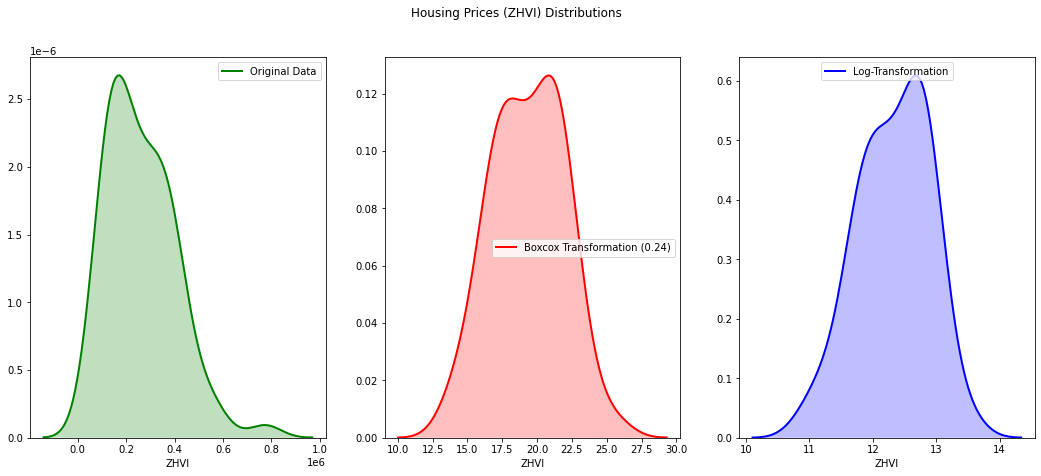

In [6]:
fig, ax = plt.subplots(1,3, figsize = (18, 7))
sns.distplot(price_crime_summary.ZHVI, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Original Data", color ="green", ax = ax[0]) 
arr, lmbda = stats.boxcox(price_crime_summary['ZHVI'])
sns.distplot(np.power(price_crime_summary.ZHVI, lmbda), hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Boxcox Transformation (" + str(np.round(lmbda,2)) + ")", color ="red", ax = ax[1])
sns.distplot(np.log(price_crime_summary.ZHVI), hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Log-Transformation", color ="blue", ax = ax[2])
plt.legend(loc = 'upper center')
plt.suptitle('Housing Prices (ZHVI) Distributions')
plt.savefig('images/housing_price_distributions.png', dpi = 500)

Next we fit different regression plots to find the best fit using diagnostic plots and $R^2$.  
(Note:- On running the model, sometimes the model may not converge. In such cases simply rerun the command)  

Below we have defined functions to plot the diagnostic (residual) plots.

In [7]:
def create_residual_vs_fitted_plot(model):
    residuals = model.resid
    fitted = model.fittedvalues
    smoothed = lowess(residuals,fitted)
    top3 = abs(residuals).sort_values(ascending = False)[:3]

    plt.rcParams.update({'font.size': 16})
    plt.rcParams["figure.figsize"] = (8,7)
    fig, ax = plt.subplots()
    ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
    ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax.set_ylabel('Residuals')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Residuals vs. Fitted')
    ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

    for i in top3.index:
        ax.annotate(i,xy=(fitted[i],residuals[i]))

    plt.show()

In [8]:
def create_residual_qqplot(model):
    sorted_student_residuals = pd.Series(model.get_influence().resid_studentized_internal)
    sorted_student_residuals.index = model.resid.index
    sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
    df = pd.DataFrame(sorted_student_residuals)
    df.columns = ['sorted_student_residuals']
    df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
    rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
    top3 = rankings[:3]

    fig, ax = plt.subplots()
    x = df['theoretical_quantiles']
    y = df['sorted_student_residuals']
    ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
    ax.set_title('Normal Q-Q')
    ax.set_ylabel('Standardized Residuals')
    ax.set_xlabel('Theoretical Quantiles')
    ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
    for val in top3.index:
        ax.annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
    plt.show()


In [9]:
def create_residual_scale_location_plot(model):
    student_residuals = model.get_influence().resid_studentized_internal
    sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
    sqrt_student_residuals.index = model.resid.index
    fitted = model.fittedvalues
    smoothed = lowess(sqrt_student_residuals,fitted)
    top3 = abs(sqrt_student_residuals).sort_values(ascending = False)[:3]

    fig, ax = plt.subplots()
    ax.scatter(fitted, sqrt_student_residuals, edgecolors = 'k', facecolors = 'none')
    ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax.set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Scale-Location')
    ax.set_ylim(0,max(sqrt_student_residuals)+0.1)
    for i in top3.index:
        ax.annotate(i,xy=(fitted[i],sqrt_student_residuals[i]))
    plt.show()

### Model 1: log(ZHVI) ~ crime_rate

In [10]:
model1 = ols('I(np.log(ZHVI)) ~ crime_rate', data=price_crime_summary).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        I(np.log(ZHVI))   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     51.90
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           8.14e-10
Time:                        09:12:11   Log-Likelihood:                -36.280
No. Observations:                  66   AIC:                             76.56
Df Residuals:                      64   BIC:                             80.94
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.7769      0.081    157.139      0.000      12.614      12.939
crime_rate   -17.9774      2.495     -7.204      0.000     -22.962     -12.992
==============================================================================
Omnibus:                        1.861   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.394   Jarque-Bera (JB):                1.400
Skew:                           0.143   Prob(JB):                        0.496
Kurtosis:                       2.346   Cond. No.                         47.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

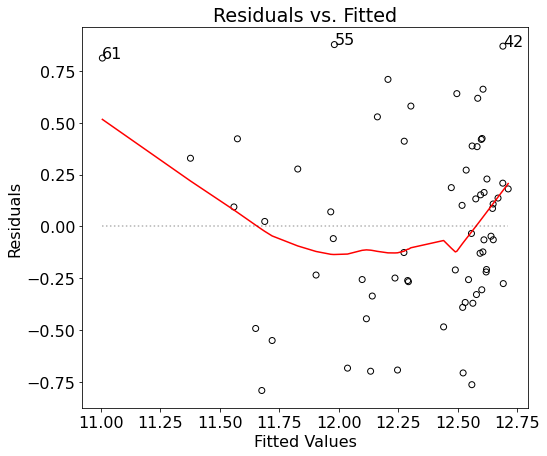

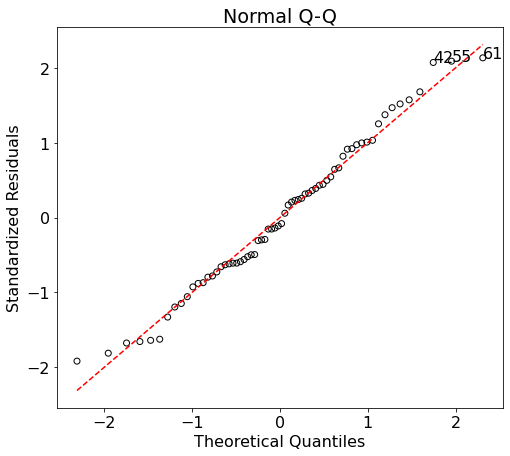

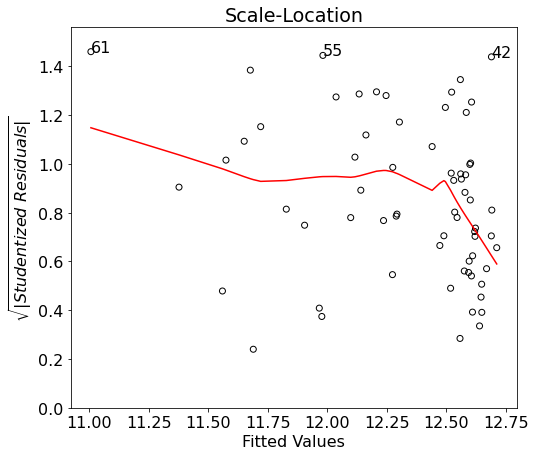

In [11]:
create_residual_vs_fitted_plot(model1)
create_residual_qqplot(model1)
create_residual_scale_location_plot(model1)

### Model 2: log(ZHVI) ~ sqrt(crime_rate)

In [12]:
model2 = ols('I(np.log(ZHVI)) ~ I(np.sqrt(crime_rate))', data=price_crime_summary).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        I(np.log(ZHVI))   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     60.46
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           8.01e-11
Time:                        09:12:20   Log-Likelihood:                -33.928
No. Observations:                  66   AIC:                             71.86
Df Residuals:                      64   BIC:                             76.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 13.2654      0.131    101.569      0.000      13.004      13.526
I(np.sqrt(crime_rate))    -6.4343      0.827     -7.776      0.000      -8.087      -4.781
==============================================================================
Omnibus:                        1.615   Durbin-Watson:                   2.199
Prob(Omnibus):                  0.446   Jarque-Bera (JB):                1.465
Skew:                           0.235   Prob(JB):                        0.481
Kurtosis:                       2.441   Cond. No.                         16.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

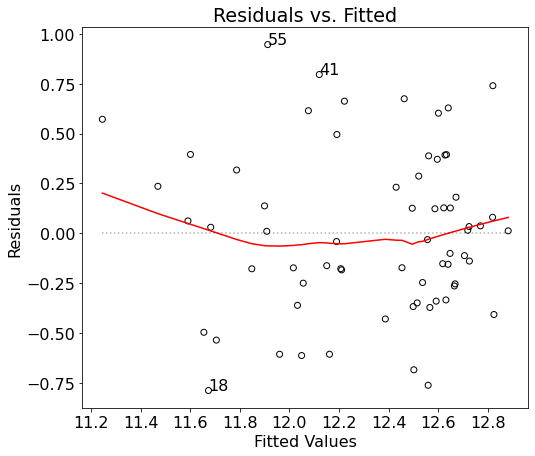

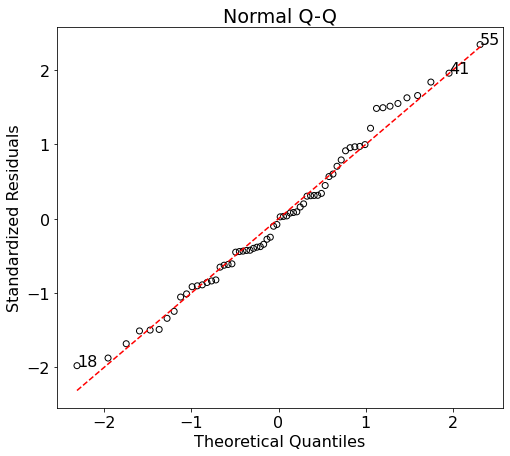

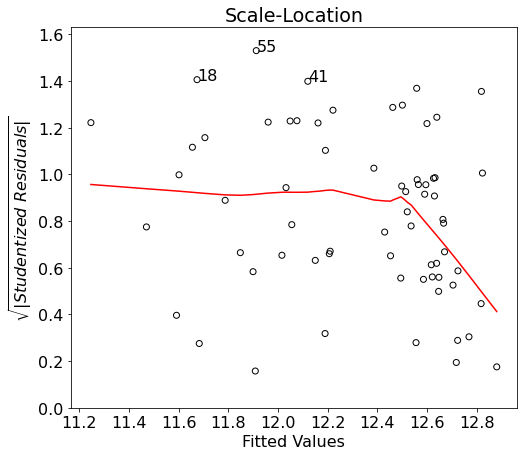

In [13]:
create_residual_vs_fitted_plot(model2)
create_residual_qqplot(model2)
create_residual_scale_location_plot(model2)

### Model 3: log(ZHVI) ~ log(crime_rate)

In [14]:
model3 = ols('I(np.log(ZHVI)) ~ I(np.log(crime_rate))', data=price_crime_summary).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        I(np.log(ZHVI))   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     61.25
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           6.53e-11
Time:                        09:12:37   Log-Likelihood:                -33.721
No. Observations:                  66   AIC:                             71.44
Df Residuals:                      64   BIC:                             75.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                10.3750      0.255     40.730      0.000       9.866      10.884
I(np.log(crime_rate))    -0.4858      0.062     -7.826      0.000      -0.610      -0.362
==============================================================================
Omnibus:                        1.462   Durbin-Watson:                   2.200
Prob(Omnibus):                  0.481   Jarque-Bera (JB):                1.494
Skew:                           0.317   Prob(JB):                        0.474
Kurtosis:                       2.624   Cond. No.                         21.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

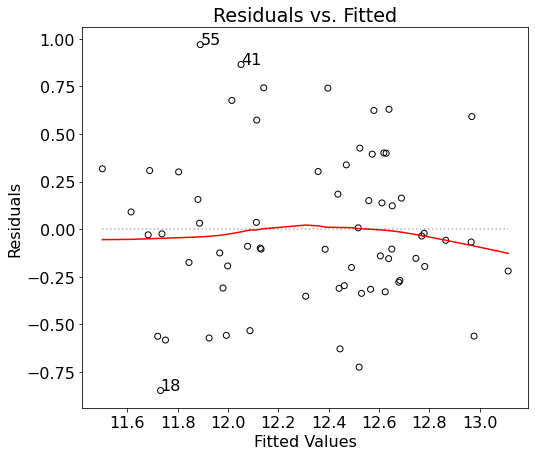

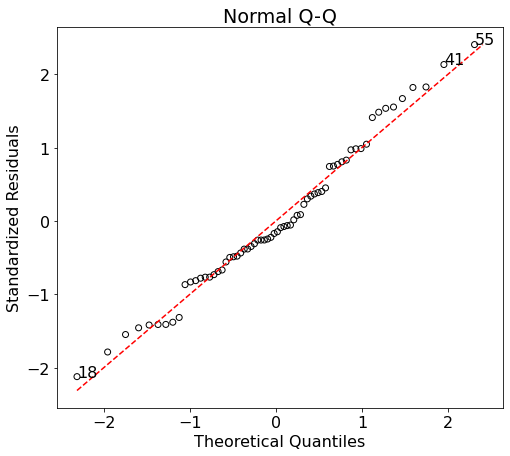

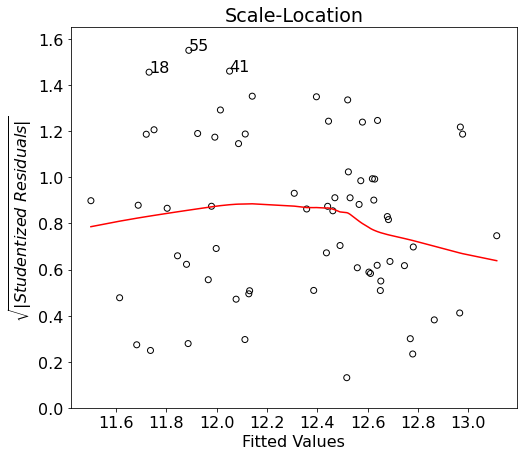

In [15]:
create_residual_vs_fitted_plot(model3)
create_residual_qqplot(model3)
create_residual_scale_location_plot(model3)

On comparison of the $R^2$ values as well as the diagnostic plots, we find that Model 3 is the best fit. Thus we find that the relationship between housing prices and crime rates is **log(price) ~ log(crime_rate)**. 
We can see the fitted plot for this relationship below. The output plots are saved under the [`images`](images/) folder.  

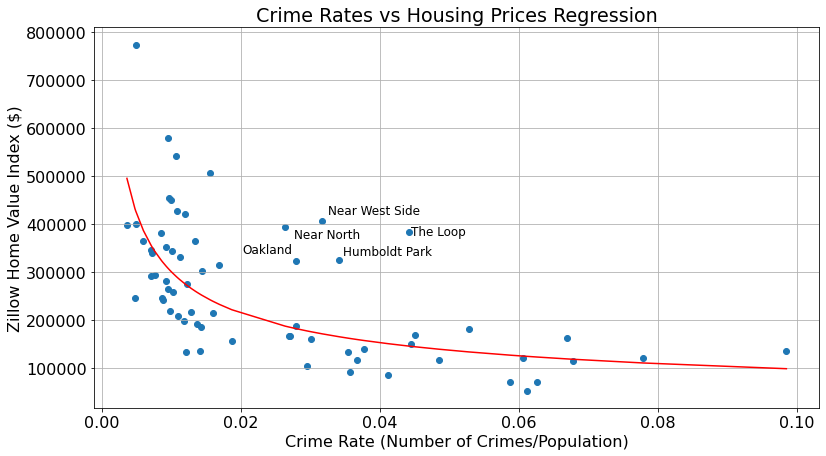

In [16]:
from adjustText import adjust_text
fig, ax = plt.subplots(figsize = (13, 7))
ax.xaxis.grid()
ax.yaxis.grid()
texts = []
ax.set_xlabel('Crime Rate (Number of Crimes/Population)')
ax.set_ylabel('Zillow Home Value Index ($)')
ax.set_title('Crime Rates vs Housing Prices Regression')
ax.scatter(price_crime_summary['crime_rate'], price_crime_summary['ZHVI'])
plt.plot(price_crime_summary['crime_rate'], np.exp(model3.fittedvalues), 'r')
for index, point in price_crime_summary.iterrows():
    if (point['ZHVI']>300000 and point['crime_rate']>0.02):
        texts.append(ax.text(point['crime_rate'], point['ZHVI'], str(point['RegionName']), va = 'center', ha = 'left', fontsize = 12))
        adjust_text(texts)
fig.savefig('images/crime_vs_prices_regression.png', dpi = 500)

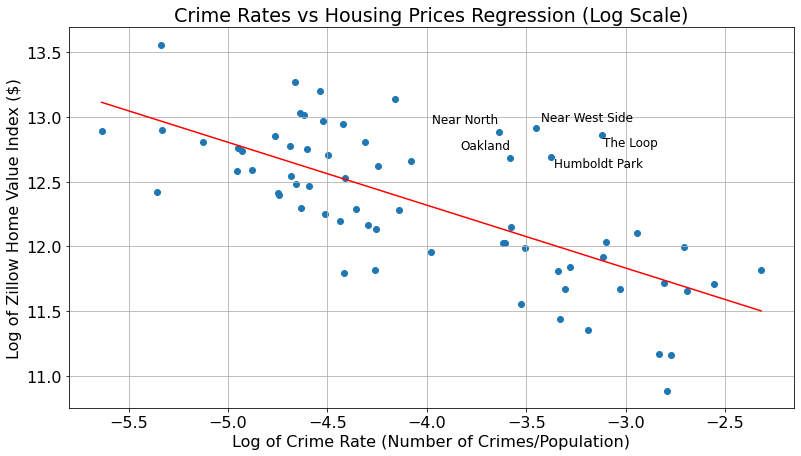

In [17]:
from adjustText import adjust_text
fig, ax = plt.subplots(figsize = (13, 7))
ax.xaxis.grid()
ax.yaxis.grid()
#ax.set_xlim(None, 0.4)
texts = []
ax.set_xlabel('Log of Crime Rate (Number of Crimes/Population)')
ax.set_ylabel('Log of Zillow Home Value Index ($)')
ax.set_title('Crime Rates vs Housing Prices Regression (Log Scale)')
ax.scatter(np.log(price_crime_summary['crime_rate']), np.log(price_crime_summary['ZHVI']))
plt.plot(np.log(price_crime_summary['crime_rate']), model3.fittedvalues, 'r')
for index, point in price_crime_summary.iterrows():
    if (point['ZHVI']>300000 and point['crime_rate']>0.02):
        texts.append(ax.text(np.log(point['crime_rate']), np.log(point['ZHVI']), str(point['RegionName']), va = 'center', ha = 'left', fontsize = 12))
        adjust_text(texts)
fig.savefig('images/crime_vs_prices_regression_log_scaled.png', dpi = 500)

In [18]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        I(np.log(ZHVI))   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     61.25
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           6.53e-11
Time:                        09:13:24   Log-Likelihood:                -33.721
No. Observations:                  66   AIC:                             71.44
Df Residuals:                      64   BIC:                             75.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                10.3750      0.255     40.730      0.000       9.866      10.884
I(np.log(crime_rate))    -0.4858      0.062     -7.826      0.000      -0.610      -0.362
==============================================================================
Omnibus:                        1.462   Durbin-Watson:                   2.200
Prob(Omnibus):                  0.481   Jarque-Bera (JB):                1.494
Skew:                           0.317   Prob(JB):                        0.474
Kurtosis:                       2.624   Cond. No.                         21.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Results

We observe from the model summary that the p-value for the coefficient of the slope is 0.000 indicating that there is indeed a relationship between the crime rate and the housing prices. The coefficient of the slope is negative (-0.49), indicating that neighborhoods with higher crime rates tend to have lower median housing prices.  
We interpret the coefficients of this model as:  
***For every 10% increase in the crime rate there is a corresponding 4.52% decrease in the housing prices.***

## Is Crime Rate a good Predictor for Housing Prices?

The $R^2$ value of the model is around 0.49 indicating that the model is a decent predictor for the housing prices.  

However I decided to add a few other variables to the model to improve the predictions. I decided to find the domestic crime rates as I feel that domestic crimes would have a greater impact on the housing prices than compared to crime rates. In order to test this, I create a column called `domestic_crime_rate`.

In [19]:
crime_rate_extended_data = final_data.groupby(['RegionName', 'ZHVI', 'population']).agg({'ID': 'count', 'Domestic': 'sum'}).reset_index()
crime_rate_extended_data = crime_rate_extended_data.rename(columns = {'ID':'number_of_crimes', 'Domestic': 'number_of_domestic_crimes'})
crime_rate_extended_data['crime_rate'] = crime_rate_extended_data['number_of_crimes']/crime_rate_extended_data['population']
crime_rate_extended_data['domestic_crime_rate'] = crime_rate_extended_data['number_of_domestic_crimes']/crime_rate_extended_data['population']
crime_rate_extended_data = crime_rate_extended_data.sort_values(by = ['domestic_crime_rate', 'crime_rate'], ascending = True)

In [20]:
domestic_crimes_model = ols('np.log(ZHVI) ~ I(np.log(domestic_crime_rate))', crime_rate_extended_data).fit()

domestic_crimes_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(ZHVI)   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     134.3
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           2.29e-17
Time:                        09:13:28   Log-Likelihood:                -18.553
No. Observations:                  66   AIC:                             41.11
Df Residuals:                      64   BIC:                             45.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          9.7777      0.224     43.698      0.000       9.331      10.225
I(np.log(domestic_crime_rate))    -0.5159      0.045    -11.590      0.000      -0.605      -0.427
==============================================================================
Omnibus:                        0.376   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.829   Jarque-Bera (JB):                0.545
Skew:                           0.117   Prob(JB):                        0.761
Kurtosis:                       2.621   Cond. No.                         29.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Results

We can see that the $R^2$ value of this model has increased from 0.489 to 0.677. Thus the domestic crime rate is a better model than the crime rates. Moreover, we also see that the slope of the model has also become more negative (from -0.4858	to -0.5159). From this we can conclude that the domestic crime rate has a more negative impact on the housing prices.  
From the new model we infer:  
***For every 10% increase in domestic crime rates, there is a corresponding 4.8% decrease in the housing prices.***

---

## Q2: Do different types of crimes have different effects on the housing prices?

In order to test whether different crimes have different effects on the housing prices, I fit a linear regression model with an interaction term `crime_type:crime_rate`. Based on the coefficients and the p-values of the coefficients we will be able to tell if the crime rate of different crimes have different effects on the housing prices.  

First I prepare the data for the analysis by aggregating the number of crimes for different neighborhoods based on crime type. Note that from the previous analysis we found that domestic crime rates have a higher impact on the housing prices. Thus for this analysis I will only be conidering domestic crimes.

In [21]:
price_crime_type_summary = final_data[final_data['Domestic']==True].groupby(['RegionName', 'ZHVI', 'population', 'Primary Type'])['ID'].count().reset_index()
price_crime_type_summary = price_crime_type_summary.rename(columns = {'ID': 'number_of_crimes', 'Primary Type': 'crime_type'})
price_crime_type_summary['crime_rate'] = price_crime_type_summary['number_of_crimes']/price_crime_type_summary['population']
price_crime_type_summary['log_crime_rate'] = np.log(price_crime_type_summary['crime_rate'])
price_crime_type_summary = price_crime_type_summary.sort_values(by = 'log_crime_rate')

In [22]:
price_crime_type_summary.head()

,RegionName,ZHVI,population,crime_type,number_of_crimes,crime_rate,log_crime_rate
132,Lake View,541659.083333,94368,SEX OFFENSE,1,0.000011,-11.454957
130,Lake View,541659.083333,94368,HOMICIDE,1,0.000011,-11.454957
268,West Town,507358.333333,82236,ROBBERY,1,0.000012,-11.317348
161,Near North,393849.833333,80484,ROBBERY,1,0.000012,-11.295814
144,Logan Square,427836.500000,72791,PROSTITUTION,1,0.000014,-11.195348


In [23]:
crime_type_model = ols('np.log(ZHVI) ~ I(np.log(crime_rate)):crime_type', data=price_crime_type_summary).fit()
crime_type_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(ZHVI)   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     33.97
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           1.07e-36
Time:                        09:13:35   Log-Likelihood:                -147.95
No. Observations:                 276   AIC:                             313.9
Df Residuals:                     267   BIC:                             346.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        9.1092      0.202     45.183      0.000       8.712       9.506
I(np.log(crime_rate)):crime_type[ARSON]                         -0.2807      0.023    -12.192      0.000      -0.326      -0.235
I(np.log(crime_rate)):crime_type[BATTERY]                       -0.6362      0.040    -15.852      0.000      -0.715      -0.557
I(np.log(crime_rate)):crime_type[HOMICIDE]                      -0.2978      0.023    -13.190      0.000      -0.342      -0.253
I(np.log(crime_rate)):crime_type[KIDNAPPING]                    -0.2938      0.022    -13.307      0.000      -0.337      -0.250
I(np.log(crime_rate)):crime_type[OFFENSE INVOLVING CHILDREN]    -0.4096      0.026    -15.731      0.000      -0.461      -0.358
I(np.log(crime_rate)):crime_type[PROSTITUTION]                  -0.3232      0.032     -9.958      0.000      -0.387      -0.259
I(np.log(crime_rate)):crime_type[ROBBERY]                       -0.3261      0.022    -14.718      0.000      -0.370      -0.282
I(np.log(crime_rate)):crime_type[SEX OFFENSE]                   -0.3449      0.022    -15.349      0.000      -0.389      -0.301
==============================================================================
Omnibus:                        2.871   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.238   Jarque-Bera (JB):                2.537
Skew:                          -0.207   Prob(JB):                        0.281
Kurtosis:                       3.222   Cond. No.                         35.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that the p-values for all the crime types are 0.000 indicating that the coefficients are significant for each crime type. We also see that the slopes vary for different crime types. 

In order to visualize the different slopes better we plot the fits for different crime types. The output plots are saved in the [`images`](images/) folder.

In [24]:
crime_type_models = {}
for crime_type in price_crime_type_summary['crime_type']:
    crime_type_models[crime_type] = ols('np.log(ZHVI)~I(np.log(crime_rate))', data = price_crime_type_summary[price_crime_type_summary['crime_type']==crime_type]).fit()

In [25]:
def create_multiple_regression_fit_plot_log(model, x, y, label):
    rcParams['figure.figsize'] = 15, 8
    plt.scatter(np.log(x), np.log(y))
    plt.grid(True, alpha = 0.6)
    plt.xlabel('Crime Rate')
    plt.ylabel('Zillow Home Value Index ($)')
    plt.plot(np.log(x), model.fittedvalues, label = label)
    plt.legend(fontsize = 14, title='Crime Type (slope)')

In [26]:
#sorting the crime types by the slopes
crime_type_slopes = {crime_type: crime_type_models[crime_type].params['I(np.log(crime_rate))'] for crime_type in crime_type_models}
crime_type_slopes= {k: v for k, v in sorted(crime_type_slopes.items(), key=lambda item: item[1])}
crime_type_slopes

{'PROSTITUTION': -2.2377671419500373,
 'ARSON': -0.6733681065560866,
 'BATTERY': -0.5117311898371548,
 'SEX OFFENSE': -0.4707937522524963,
 'KIDNAPPING': -0.42842539816796155,
 'OFFENSE INVOLVING CHILDREN': -0.42680174141124183,
 'ROBBERY': -0.3989380916184654,
 'HOMICIDE': -0.33042177953513363}

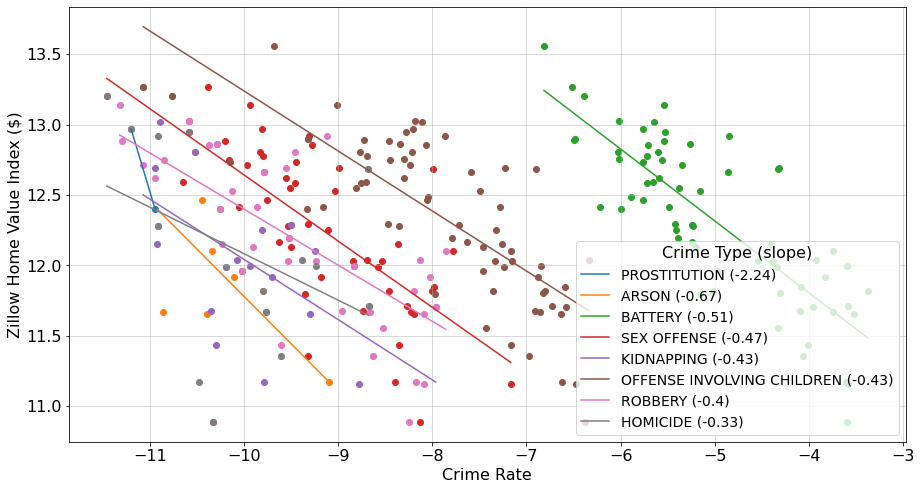

In [27]:
for crime_type in crime_type_slopes:
        create_multiple_regression_fit_plot_log(crime_type_models[crime_type], price_crime_type_summary[price_crime_type_summary['crime_type'] == crime_type]['crime_rate'], price_crime_type_summary[price_crime_type_summary['crime_type'] == crime_type]['ZHVI'], crime_type + " ("+ str(crime_type_slopes[crime_type].round(2))+ ")")
plt.savefig('images/crimes_type_vs_prices_log_scale.png', dpi = 500)

Note that we have only 2 data points for PROSTITUTION, and so we cannot rely on it's results. Therefore I choose to omit it from the results.

### Results

From this analysis we thus conclude that different types of crimes do indeed have different impacts on the housing prices. We see that ARSON has the most negative impact on the housing prices followed by BATTER, SEX OFFENSE, KIDNAPPING, OFFENSE INVOLVING CHILDREN, ROBBERY and finally HOMICIDE. This list is telling of the problems that impact the society the most. Law enforcers and policy makers must thus focus on these types of crimes to make communities more secure and increase community rankings.

## X. Discussion

It is to be noted that the results of the analysis do not necessarily imply a direct causation. The results of this analysis are purely based on observational data. It must also be noted that there may be other counfounding variables (eg:- neighborhood income, primary industry, etc.) which may also have significant impacts on the housing prices. However, the goal of this analysis is to study the relationship between crime rates and housing prices and thus other variables have not been included. However, these attributes pose potential for more analysis in the future. For eg. the relationship between crime rates, income and housing prices.

## XI. Conclusions

We summarize our conclusions from the analysis as follows-

1. Safety is indeed an important indicator for the welfare of a community. Communities with lower crime rates are considered safer and thus are more popular housing choices for prospective buyers and sellers. Thus housing prices are indeed higher for areas with lower crime rates. For every 10% increase in the crime rate, there is a corresponding 4.52% decrease in the housing prices. Crime rates are decent predictors for housing prices in an neighborhood ($R^2 = 0.49)$.  
2. Domestic crimes have a more negative impact on housing prices than other crimes. For every 10% increase in domestic crime rates, there is a corresponding 4.8% decrease in the housing prices. Domestic crimes are also better predictors for housing prices than regular crime rates ($R^2 = 0.68$).  
3. The domestic crime rates of different types of crimes have varying impacts on the housing prices. Arson has the most negative impact on the housing prices as an increase of 10% arson crimes has a corresponding 6.2% decrease in housing prices. This is followed by battery (-4.7%), sexual offences (-4.4%), kidnapping (-4.0%), offences involving children (-4.0%),  robbery (-3.7%) and homicide (-3.1%). This is suggestive of the more problematic crimes in the city which have an impact on the community ratings.  

It would thus be beneficial for law enforcers and policy makers to understand the impact of different types of crimes and enforce stricter rules in order to make communities safer and more desirable for settlement.